In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"YOUR-USERNAME","key":"YOUR-API-KEY"}' > ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kartik2112/fraud-detection

 97% 195M/202M [00:01<00:00, 104MB/s]
100% 202M/202M [00:01<00:00, 119MB/s]


In [ ]:
!unzip -o fraud-detection.zip

Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [ ]:
train_master = pd.read_csv('fraudTrain.csv', index_col=0)
test_master = pd.read_csv('fraudTest.csv', index_col=0)

# Utility functions for feature engineering

In [ ]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

In [ ]:
def get_txn_history(txns, windows=[7, 15, 30, 60]):
    txns = txns.sort_values('trans_date_trans_time')
    txns.index = txns.trans_date_trans_time
    
    for window in windows:
        total_amt = txns['amt'].rolling(window, min_periods = 1).sum()
        count_amt = txns['amt'].rolling(window, min_periods = 1).count()

        avg_amt = total_amt/count_amt

        txns[f'count_amt_{window}_days'] = list(count_amt)
        txns[f'count_avg_{window}_days'] = list(avg_amt)

    txns.reset_index(drop = True)
    return txns

# Transformation, scaling and oversampling pipeline

In [ ]:
def transform(df):
    df = df.groupby('cc_num').apply(lambda x: get_txn_history(x, windows=[7, 15, 30]))
    df.reset_index(drop=True, inplace = True)
    df = df.sort_values('trans_date_trans_time')

    # Fraud by merchant
    fraud_by_merch = df[(df['is_fraud'] == 1)].groupby('merchant')['merchant'].count().to_dict()
    df['fraud_by_merch'] = df['merchant'].transform(lambda m: fraud_by_merch.get(m, 0))

    # Retain only month and year of txn
    df['trans_month'] = pd.DatetimeIndex(df['trans_date_trans_time']).month
    df['trans_year'] = pd.DatetimeIndex(df['trans_date_trans_time']).year

    # Calculate distance between user and merchant
    df['distance_bet_user_merchant'] = haversine_np(
        df['lat'], df['long'],
        df['merch_lat'], df['merch_long']
    )

    # Encode gender
    df['gender'] = df['gender'].transform(lambda g: 1 if g == 'F' else 0)

    # One hot encoding of categories
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

    # Calculate age of user at the time of txn
    df['dob'] = pd.to_datetime(df['dob'])
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]').apply(pd.to_numeric)

    # Whether txn was at night
    df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))

    # Whether txn was on a weekend
    df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))

    # Drop columns that are no longer required
    df.drop(axis=1, inplace=True, columns=[
            'trans_num', 'street', 'first', 'last', 'unix_time', 'city', 'state',
            'trans_date_trans_time', 'dob', 'job', 'cc_num', 'merchant',
            'zip', 'lat', 'long', 'merch_lat', 'merch_long',
        ]
    )

    return df

In [ ]:
from sklearn.utils import resample

def oversample(df):
    majority = df[(df['is_fraud'] == 0)]
    minority = df[(df['is_fraud'] == 1)]

    minority_upsampled = resample(
        minority, replace=True, 
        n_samples=majority.shape[0], random_state=42
    )
    
    return pd.concat([minority_upsampled, majority])

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale(df):
    std_scaler = StandardScaler()
    return std_scaler.fit_transform(df)

# Model evaluation helper functions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X, y):
    score = model.score(X, y)
    print(f"Accuracy: {score:.2f}")
    print(confusion_matrix(y, model.predict(X)))
    print(classification_report(model.predict(X), y))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_auc(model, X, y):
    roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

# Data pre-processing

In [ ]:
train_X = transform(train_master)

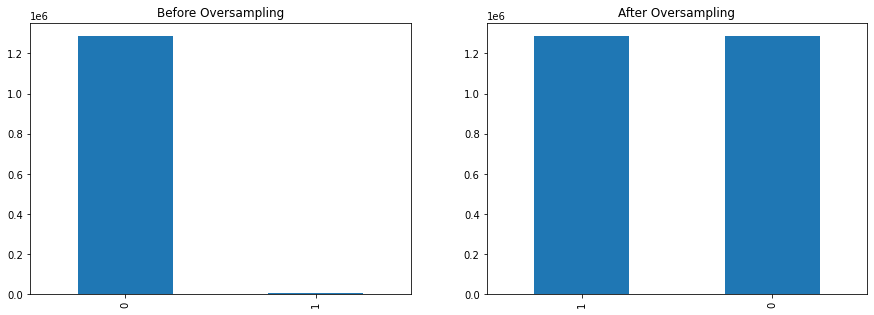

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Oversampling')
pd.Series(train_X['is_fraud']).value_counts().plot.bar(ax=ax1)

train_X = oversample(train_X)

ax2.set_title('After Oversampling') 
pd.Series(train_X['is_fraud']).value_counts().plot.bar(ax=ax2)
plt.show()

In [ ]:
train_y = train_X['is_fraud']
train_X.drop(axis=1, columns=['is_fraud'], inplace=True)

In [ ]:
train_X = scale(train_X)

In [ ]:
test_X = transform(test_master)

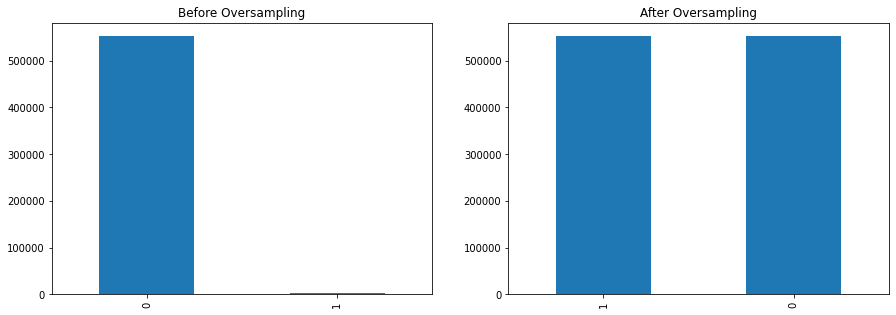

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Oversampling')
pd.Series(test_X['is_fraud']).value_counts().plot.bar(ax=ax1)

test_X = oversample(test_X)

ax2.set_title('After Oversampling') 
pd.Series(test_X['is_fraud']).value_counts().plot.bar(ax=ax2)
plt.show()

In [ ]:
test_y = test_X['is_fraud']
test_X.drop(axis=1, columns=['is_fraud'], inplace=True)

In [ ]:
test_X = scale(test_X)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_X, train_y)

LogisticRegression()

In [ ]:
evaluate_model(model, train_X, train_y)

Accuracy: 0.94
[[1234682   54487]
 [  98076 1191093]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94   1332758
           1       0.92      0.96      0.94   1245580

    accuracy                           0.94   2578338
   macro avg       0.94      0.94      0.94   2578338
weighted avg       0.94      0.94      0.94   2578338



### Testing

In [ ]:
evaluate_model(model, test_X, test_y)

Accuracy: 0.93
[[529040  24534]
 [ 48232 505342]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94    577272
           1       0.91      0.95      0.93    529876

    accuracy                           0.93   1107148
   macro avg       0.93      0.94      0.93   1107148
weighted avg       0.94      0.93      0.93   1107148



No handles with labels found to put in legend.


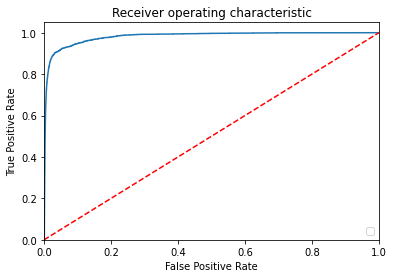

In [ ]:
plot_roc_auc(model, test_X, test_y)

# Logistic Regression with Cross Validation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=5)
model.fit(train_X, train_y)

LogisticRegressionCV(cv=5)

In [ ]:
evaluate_model(model, train_X, train_y)

Accuracy: 0.94
[[1235617   53552]
 [  98767 1190402]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94   1334384
           1       0.92      0.96      0.94   1243954

    accuracy                           0.94   2578338
   macro avg       0.94      0.94      0.94   2578338
weighted avg       0.94      0.94      0.94   2578338



### Testing

In [ ]:
evaluate_model(model, test_X, test_y)

Accuracy: 0.93
[[529402  24172]
 [ 49559 504015]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93    578961
           1       0.91      0.95      0.93    528187

    accuracy                           0.93   1107148
   macro avg       0.93      0.93      0.93   1107148
weighted avg       0.93      0.93      0.93   1107148



No handles with labels found to put in legend.


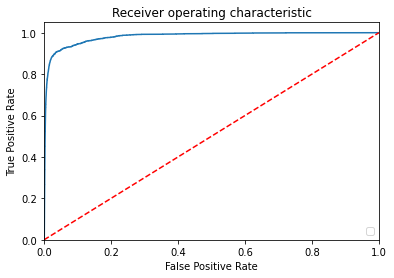

In [ ]:
plot_roc_auc(model, test_X, test_y)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(train_X, train_y)

DecisionTreeClassifier()

In [ ]:
evaluate_model(model, train_X, train_y)

Accuracy: 1.00
[[1289169       0]
 [      0 1289169]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       1.00      1.00      1.00   1289169

    accuracy                           1.00   2578338
   macro avg       1.00      1.00      1.00   2578338
weighted avg       1.00      1.00      1.00   2578338



### Testing

In [ ]:
evaluate_model(model, test_X, test_y)

Accuracy: 0.89
[[553131    443]
 [122859 430715]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    675990
           1       0.78      1.00      0.87    431158

    accuracy                           0.89   1107148
   macro avg       0.89      0.91      0.89   1107148
weighted avg       0.91      0.89      0.89   1107148



No handles with labels found to put in legend.


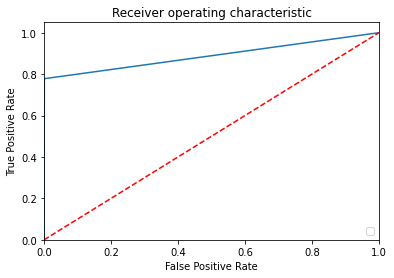

In [ ]:
plot_roc_auc(model, test_X, test_y)

# Decision Tree with Cross Validation (Grid Search)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [50, 100],
}

dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=params,
    cv=5
)

grid_search.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [50, 100]})

In [ ]:
evaluate_model(grid_search, train_X, train_y)

Accuracy: 1.00
[[1289169       0]
 [      0 1289169]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       1.00      1.00      1.00   1289169

    accuracy                           1.00   2578338
   macro avg       1.00      1.00      1.00   2578338
weighted avg       1.00      1.00      1.00   2578338



### Testing

In [ ]:
evaluate_model(grid_search, test_X, test_y)

Accuracy: 0.89
[[553142    432]
 [123069 430505]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    676211
           1       0.78      1.00      0.87    430937

    accuracy                           0.89   1107148
   macro avg       0.89      0.91      0.89   1107148
weighted avg       0.91      0.89      0.89   1107148



No handles with labels found to put in legend.


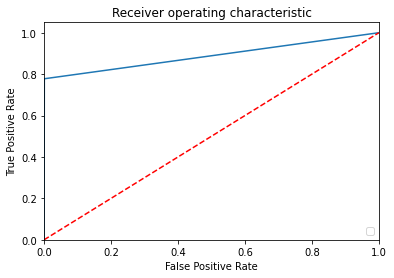

In [ ]:
plot_roc_auc(grid_search, test_X, test_y)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(train_X, train_y)

RandomForestClassifier()

In [ ]:
evaluate_model(model, train_X, train_y)

Accuracy: 1.00
[[1289169       0]
 [      0 1289169]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       1.00      1.00      1.00   1289169

    accuracy                           1.00   2578338
   macro avg       1.00      1.00      1.00   2578338
weighted avg       1.00      1.00      1.00   2578338



### Testing

In [ ]:
evaluate_model(model, test_X, test_y)

Accuracy: 0.89
[[553440    134]
 [116381 437193]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90    669821
           1       0.79      1.00      0.88    437327

    accuracy                           0.89   1107148
   macro avg       0.89      0.91      0.89   1107148
weighted avg       0.92      0.89      0.90   1107148



No handles with labels found to put in legend.


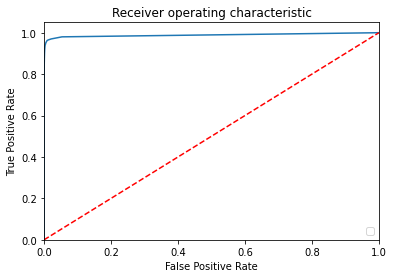

In [ ]:
plot_roc_auc(model, test_X, test_y)

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(train_X, train_y)

GaussianNB()

In [ ]:
evaluate_model(model, train_X, train_y)

Accuracy: 0.88
[[1237702   51467]
 [ 257773 1031396]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89   1495475
           1       0.80      0.95      0.87   1082863

    accuracy                           0.88   2578338
   macro avg       0.88      0.89      0.88   2578338
weighted avg       0.89      0.88      0.88   2578338



### Testing

In [ ]:
evaluate_model(model, test_X, test_y)

Accuracy: 0.87
[[523621  29953]
 [108694 444880]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.88    632315
           1       0.80      0.94      0.87    474833

    accuracy                           0.87   1107148
   macro avg       0.87      0.88      0.87   1107148
weighted avg       0.88      0.87      0.88   1107148



No handles with labels found to put in legend.


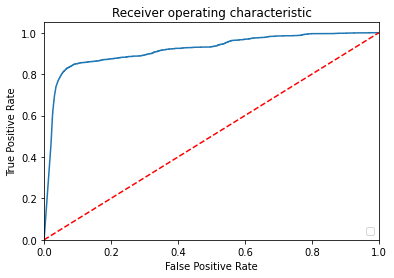

In [ ]:
plot_roc_auc(model, test_X, test_y)